In [1]:
from transformers import AutoTokenizer,  AutoModel
import torch
import torch.optim as optim
from torchcrf import CRF
from torch.utils.data import Dataset
import torch.nn as nn
from torch.utils.data import DataLoader
from seqeval.metrics import classification_report, precision_score, recall_score, f1_score
from __future__ import print_function
import matplotlib.pyplot as plt


In [2]:
import os
import sys
import codecs
import re
import numpy as np
from collections import OrderedDict
import datetime

In [3]:
import warnings

# 忽略特定的 UserWarning
warnings.filterwarnings("ignore", message="<START> seems not to be NE tag.", category=UserWarning)
# 忽略特定的 UndefinedMetricWarning
warnings.filterwarnings("ignore", message="Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.")

In [4]:
now = datetime.datetime.now()
timestamp = now.strftime("%Y-%m-%d_%H-%M-%S")

In [ ]:
#parameters for the Model
parameters = OrderedDict()
parameters['train'] = "./train.txt" #Path to train file
parameters['validation'] = "./valid.txt" #Path to test file
parameters['test'] = "./test.txt" #Path to dev file
parameters['tag_scheme'] = "BIOES" #BIO or BIOES
parameters['lower'] = True # Boolean variable to control lowercasing of words
parameters['zeros'] =  True # Boolean variable to control replacement of  all digits by 0 
models_path = "./models/" #path to saved models

#Constants
PAD_TAG = '<PAD>'

In [6]:
print(parameters)

OrderedDict({'train': './train.txt', 'validation': './valid.txt', 'test': './test.txt', 'tag_scheme': 'BIOES', 'lower': True, 'zeros': True, 'char_dim': 30, 'word_dim': 100, 'word_lstm_dim': 200, 'word_bidirect': True, 'embedding_path': './glove.6B.100d.txt', 'all_emb': 1, 'crf': 1, 'dropout': 0.5, 'epoch': 50, 'weights': '', 'name': '2025-04-21_01-42-14', 'gradient_clip': 5.0, 'char_mode': 'CNN', 'reload': './models/pre-trained-model'})


In [7]:
#To stored model
name = parameters['name']
model_name = models_path + name #get_name(parameters)
print(model_name)

if not os.path.exists(models_path):
    os.makedirs(models_path)

./models/2025-04-21_01-42-14


# 1. Load and preprocess data

In [8]:
# 將輸入字串 s 中的所有阿拉伯數字（0-9）都替換成零（'0'）
def zero_digits(s):
    """
    Replace every digit in a string by a zero.
    """
    return re.sub('\d', '0', s)

# 提供了一個選項 zeros，用來決定是否將載入的句子中的數字替換成零
# 會根據空行來判斷句子的邊界，並且會忽略以 'DOCSTART' 開頭的行
def load_sentences(path, zeros):
    """
    Load sentences. A line must contain at least a word and its tag.
    Sentences are separated by empty lines.
    """
    sentences = []
    sentence = []
    for line in codecs.open(path, 'r', 'utf8'):
        line = zero_digits(line.rstrip()) if zeros else line.rstrip()
        if not line:
            if len(sentence) > 0:
                if 'DOCSTART' not in sentence[0][0]:
                    sentences.append(sentence)
                sentence = []
        else:
            word = line.split()
            # 確保每一行至少包含兩個元素（一個詞和一個標籤）
            if len(word) >= 2 or (len(word) == 1 and word != ['O']):
                sentence.append(word)
            #     print(word)
            # assert len(word) >= 2 and word != ['O']
            
    if len(sentence) > 0:
        if 'DOCSTART' not in sentence[0][0]:
            sentences.append(sentence)
    return sentences

<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
C:\Users\user\AppData\Local\Temp\ipykernel_48620\2311095135.py:6: SyntaxWarning: invalid escape sequence '\d'
  return re.sub('\d', '0', s)


In [9]:
train_sentences = load_sentences(parameters['train'], parameters['zeros'])
valid_sentences = load_sentences(parameters['validation'], parameters['zeros'])
test_sentences = load_sentences(parameters['test'], parameters['zeros'])


In [10]:
print(train_sentences[0])
print(valid_sentences[0])
print(test_sentences[0])

[['The', 'O'], ['admin@000', 'B-HackOrg'], ['has', 'O'], ['largely', 'O'], ['targeted', 'O'], ['organizations', 'O'], ['involved', 'O'], ['in', 'O'], ['financial', 'B-Idus'], [',', 'O'], ['economic', 'B-Idus'], ['and', 'O'], ['trade', 'B-Idus'], ['policy', 'I-Idus'], [',', 'O'], ['typically', 'O'], ['using', 'O'], ['publicly', 'B-Tool'], ['available', 'I-Tool'], ['RATs', 'I-Tool'], ['such', 'O'], ['as', 'O'], ['Poison', 'B-Tool'], ['Ivy', 'I-Tool'], [',', 'O'], ['as', 'O'], ['well', 'O'], ['some', 'O'], ['non-public', 'B-Tool'], ['backdoors', 'I-Tool'], ['.', 'O']]
[['We', 'O'], ['believe', 'O'], ['that', 'O'], ['these', 'O'], ['industries', 'O'], ['have', 'O'], ['also', 'O'], ['been', 'O'], ['targeted', 'O'], ['as', 'O'], ['part', 'O'], ['of', 'O'], ['a', 'O'], ['larger', 'O'], ['supply-chain', 'B-OffAct'], ['attack', 'I-OffAct'], ['in', 'O'], ['order', 'O'], ['for', 'O'], ['Orangeworm', 'O'], ['to', 'O'], ['get', 'O'], ['access', 'O'], ['to', 'O'], ['their', 'O'], ['intended', 'O'], 

# 2. Build label mappings

BIO 標註方案 (Beginning, Inside, Outside):

B-TYPE: 一個命名實體的開始。TYPE 指的是實體的類型。  
I-TYPE: 一個命名實體的內部。表示這個詞是前面同類型命名實體的延續。  
O: 這個詞不是任何命名實體的一部分。  

SamFile: 檔案，如:Vietnam.exe 、malicious file、decoy documents
Way: 攻擊方法，如:spear、emails、lure  
SecTeam: 網路安全團隊，FireEye、Arbor、information security community  
Time: 時間，如: August 2015  
HackOrg: 駭客組織, 如: admin@338、cyber threat groups、threat actors  
Purp: 目的, 如: steal information、intelligence-gathering  
Tool: 工具, 如: CORESHELL、SPLM、JHUHUGIT  
Features: 功能, send POST requests、contain information、connect to a command and control、persistence functionality   
Org: 一般組織, 如: International Civil Aviation Organization、Bitcoin users  
Exp: 漏洞利用, 如: CVE-2015-8651、CVE-2016-1019、CVE-2016-4117  
Area: 地區, 如: Turkish、Turkey
OffAct: 攻擊行為, 如: malicious cyber activity、watering hole attacks、cyberespionage attacks  
Idus: Industrial , 如: government、enterprises、businesses、telecommunications、shipping、car、manufacturers  
O: 不屬於任何已定義的命名實體  

In [11]:
def iob2(tags):
    """
    Check that tags have a valid BIO format.
    Tags in BIO1 format are converted to BIO2.
    """
    for i, tag in enumerate(tags):
        if tag == 'O':
            continue
        split = tag.split('-')
        if len(split) != 2 or split[0] not in ['I', 'B']:
            return False
        if split[0] == 'B':
            continue
        elif i == 0 or tags[i - 1] == 'O':  # conversion IOB1 to IOB2
            tags[i] = 'B' + tag[1:]
        elif tags[i - 1][1:] == tag[1:]:
            continue
        else:  # conversion IOB1 to IOB2
            tags[i] = 'B' + tag[1:]
    return True

def iob_iobes(tags):
    """
    the function is used to convert
    BIO -> BIOES tagging
    """
    new_tags = []
    for i, tag in enumerate(tags):
        if tag == 'O':
            new_tags.append(tag)
        elif tag.split('-')[0] == 'B':
            if i + 1 != len(tags) and \
               tags[i + 1].split('-')[0] == 'I':
                new_tags.append(tag)
            else:
                new_tags.append(tag.replace('B-', 'S-'))
        elif tag.split('-')[0] == 'I':
            if i + 1 < len(tags) and \
                    tags[i + 1].split('-')[0] == 'I':
                new_tags.append(tag)
            else:
                new_tags.append(tag.replace('I-', 'E-'))
        else:
            raise Exception('Invalid IOB format!')
    return new_tags

def update_tag_scheme(sentences, tag_scheme):
    """
    Check and update sentences tagging scheme to BIO2
    Only BIO1 and BIO2 schemes are accepted for input data.
    """
    for i, s in enumerate(sentences):
        tags = [w[-1] for w in s]
        # Check that tags are given in the BIO format
        if not iob2(tags):
            s_str = '\n'.join(' '.join(w) for w in s)
            raise Exception('Sentences should be given in BIO format! ' +
                            'Please check sentence %i:\n%s' % (i, s_str))
        if tag_scheme == 'BIOES':
            new_tags = iob_iobes(tags)
            for word, new_tag in zip(s, new_tags):
                word[-1] = new_tag
        else:
            raise Exception('Wrong tagging scheme!')

In [12]:
update_tag_scheme(train_sentences, parameters['tag_scheme'])
update_tag_scheme(valid_sentences, parameters['tag_scheme'])
update_tag_scheme(test_sentences, parameters['tag_scheme'])

In [13]:
print(train_sentences[0])
print(valid_sentences[0])
print(test_sentences[0])

[['The', 'O'], ['admin@000', 'S-HackOrg'], ['has', 'O'], ['largely', 'O'], ['targeted', 'O'], ['organizations', 'O'], ['involved', 'O'], ['in', 'O'], ['financial', 'S-Idus'], [',', 'O'], ['economic', 'S-Idus'], ['and', 'O'], ['trade', 'B-Idus'], ['policy', 'E-Idus'], [',', 'O'], ['typically', 'O'], ['using', 'O'], ['publicly', 'B-Tool'], ['available', 'I-Tool'], ['RATs', 'E-Tool'], ['such', 'O'], ['as', 'O'], ['Poison', 'B-Tool'], ['Ivy', 'E-Tool'], [',', 'O'], ['as', 'O'], ['well', 'O'], ['some', 'O'], ['non-public', 'B-Tool'], ['backdoors', 'E-Tool'], ['.', 'O']]
[['We', 'O'], ['believe', 'O'], ['that', 'O'], ['these', 'O'], ['industries', 'O'], ['have', 'O'], ['also', 'O'], ['been', 'O'], ['targeted', 'O'], ['as', 'O'], ['part', 'O'], ['of', 'O'], ['a', 'O'], ['larger', 'O'], ['supply-chain', 'B-OffAct'], ['attack', 'E-OffAct'], ['in', 'O'], ['order', 'O'], ['for', 'O'], ['Orangeworm', 'O'], ['to', 'O'], ['get', 'O'], ['access', 'O'], ['to', 'O'], ['their', 'O'], ['intended', 'O'], 

# Create Mappings for Words, Characters and Tags

In [14]:
def create_dico(item_list):
    """
    Create a dictionary of items from a list of list of items.
    """
    assert type(item_list) is list
    dico = {}
    for items in item_list:
        for item in items:
            if item not in dico:
                dico[item] = 1
            else:
                dico[item] += 1
    return dico

def create_mapping(dico):
    """
    Create a mapping (item to ID / ID to item) from a dictionary.
    Items are ordered by decreasing frequency.
    """
    sorted_items = sorted(dico.items(), key=lambda x: (-x[1], x[0]))
    id_to_item = {i: v[0] for i, v in enumerate(sorted_items)}
    item_to_id = {v: k for k, v in id_to_item.items()}
    return item_to_id, id_to_item

def word_mapping(sentences, lower):
    """
    Create a dictionary and a mapping of words, sorted by frequency.
    """
    words = [[x[0].lower() if lower else x[0] for x in s] for s in sentences]
    dico = create_dico(words)
    dico['<UNK>'] = 10000000 #UNK tag for unknown words
    word_to_id, id_to_word = create_mapping(dico)
    print("Found %i unique words (%i in total)" % (
        len(dico), sum(len(x) for x in words)
    ))
    return dico, word_to_id, id_to_word

def char_mapping(sentences):
    """
    Create a dictionary and mapping of characters, sorted by frequency.
    """
    chars = ["".join([w[0] for w in s]) for s in sentences]
    dico = create_dico(chars)
    char_to_id, id_to_char = create_mapping(dico)
    print("Found %i unique characters" % len(dico))
    return dico, char_to_id, id_to_char

def tag_mapping(sentences):
    """
    Create a dictionary and a mapping of tags, sorted by frequency.
    """
    tags = [[word[-1] for word in s] for s in sentences]
    dico = create_dico(tags)
    dico[PAD_TAG] = -3
    tag_to_id, id_to_tag = create_mapping(dico)
    print("Found %i unique named entity tags" % len(dico))
    return dico, tag_to_id, id_to_tag

In [15]:
dico_words,word_to_id,id_to_word = word_mapping(train_sentences, parameters['lower'])
dico_chars, char_to_id, id_to_char = char_mapping(train_sentences)
dico_tags, tag_to_id, id_to_tag = tag_mapping(train_sentences)

Found 7733 unique words (140348 in total)
Found 121 unique characters
Found 54 unique named entity tags


In [16]:
print(id_to_tag)

{0: 'O', 1: 'S-HackOrg', 2: 'S-Area', 3: 'S-Tool', 4: 'B-Tool', 5: 'E-Tool', 6: 'S-Idus', 7: 'B-HackOrg', 8: 'E-HackOrg', 9: 'S-SamFile', 10: 'B-Org', 11: 'E-Org', 12: 'S-OffAct', 13: 'S-Exp', 14: 'B-Area', 15: 'E-Area', 16: 'S-SecTeam', 17: 'S-Time', 18: 'B-OffAct', 19: 'E-OffAct', 20: 'B-Time', 21: 'E-Time', 22: 'B-Purp', 23: 'E-Purp', 24: 'I-Features', 25: 'I-Purp', 26: 'B-Features', 27: 'E-Features', 28: 'B-Way', 29: 'E-Way', 30: 'B-SamFile', 31: 'E-SamFile', 32: 'B-Idus', 33: 'E-Idus', 34: 'I-Tool', 35: 'S-Org', 36: 'B-Exp', 37: 'E-Exp', 38: 'B-SecTeam', 39: 'E-SecTeam', 40: 'S-Way', 41: 'S-Features', 42: 'I-Exp', 43: 'I-Way', 44: 'I-OffAct', 45: 'I-Org', 46: 'I-SecTeam', 47: 'I-Time', 48: 'I-SamFile', 49: 'I-Area', 50: 'I-HackOrg', 51: 'S-Purp', 52: 'I-Idus', 53: '<PAD>'}


In [17]:
print(dico_words)
print(word_to_id)
print(id_to_word)

{'the': 7057, 'admin@000': 39, 'has': 682, 'largely': 28, 'targeted': 423, 'organizations': 309, 'involved': 62, 'in': 3078, 'financial': 245, ',': 7031, 'economic': 30, 'and': 3611, 'trade': 14, 'policy': 25, 'typically': 45, 'using': 406, 'publicly': 66, 'available': 75, 'rats': 28, 'such': 221, 'as': 1196, 'poison': 39, 'ivy': 38, 'well': 133, 'some': 147, 'non-public': 12, 'backdoors': 62, '.': 5248, 'started': 50, 'targeting': 387, 'hong': 39, 'kong': 32, 'media': 89, 'companies': 131, 'probably': 16, 'response': 16, 'to': 3975, 'political': 43, 'challenges': 2, 'china': 117, 'multiple': 121, 'china-based': 26, 'cyber': 114, 'threat': 428, 'groups': 128, 'have': 550, 'international': 24, 'past': 51, 'august': 65, '0000': 1206, 'sent': 91, 'spear': 118, 'phishing': 228, 'emails': 202, 'a': 2917, 'number': 68, 'of': 2863, 'kong-based': 6, 'including': 200, 'newspapers': 5, 'radio': 4, 'television': 5, 'actors': 288, 'previous': 75, 'activities': 114, 'against': 238, 'focused': 81, '

# Preparing final dataset

In [18]:
def lower_case(x,lower=False):
    if lower:
        return x.lower()  
    else:
        return x

In [19]:
def prepare_dataset(sentences, word_to_id, char_to_id, tag_to_id, lower=False):
    """
    Prepare the dataset. Return a list of lists of dictionaries containing:
        - word indexes
        - word char indexes
        - tag indexes
    """
    data = []
    for s in sentences:
        str_words = [w[0] for w in s]
        words = [word_to_id[lower_case(w,lower) if lower_case(w,lower) in word_to_id else '<UNK>']
                 for w in str_words]
        # Skip characters that are not in the training set
        chars = [[char_to_id[c] for c in w if c in char_to_id]
                 for w in str_words]
        tags = [tag_to_id[w[-1]] for w in s]
        data.append({
            'str_words': str_words,
            'words': words,
            'chars': chars,
            'tags': tags,
        })
    return data

train_data = prepare_dataset(
    train_sentences, word_to_id, char_to_id, tag_to_id, parameters['lower']
)
valid_data = prepare_dataset(
    valid_sentences, word_to_id, char_to_id, tag_to_id, parameters['lower']
)
test_data = prepare_dataset(
    test_sentences, word_to_id, char_to_id, tag_to_id, parameters['lower']
)
print("{} / {} / {} sentences in train / validation / test.".format(len(train_data), len(valid_data), len(test_data)))

5251 / 662 / 664 sentences in train / validation / test.


In [20]:
print(tag_to_id)
id_to_tag = {id: tag for tag, id in tag_to_id.items()}

{'O': 0, 'S-HackOrg': 1, 'S-Area': 2, 'S-Tool': 3, 'B-Tool': 4, 'E-Tool': 5, 'S-Idus': 6, 'B-HackOrg': 7, 'E-HackOrg': 8, 'S-SamFile': 9, 'B-Org': 10, 'E-Org': 11, 'S-OffAct': 12, 'S-Exp': 13, 'B-Area': 14, 'E-Area': 15, 'S-SecTeam': 16, 'S-Time': 17, 'B-OffAct': 18, 'E-OffAct': 19, 'B-Time': 20, 'E-Time': 21, 'B-Purp': 22, 'E-Purp': 23, 'I-Features': 24, 'I-Purp': 25, 'B-Features': 26, 'E-Features': 27, 'B-Way': 28, 'E-Way': 29, 'B-SamFile': 30, 'E-SamFile': 31, 'B-Idus': 32, 'E-Idus': 33, 'I-Tool': 34, 'S-Org': 35, 'B-Exp': 36, 'E-Exp': 37, 'B-SecTeam': 38, 'E-SecTeam': 39, 'S-Way': 40, 'S-Features': 41, 'I-Exp': 42, 'I-Way': 43, 'I-OffAct': 44, 'I-Org': 45, 'I-SecTeam': 46, 'I-Time': 47, 'I-SamFile': 48, 'I-Area': 49, 'I-HackOrg': 50, 'S-Purp': 51, 'I-Idus': 52, '<PAD>': 53}


In [21]:
print(train_data[0])
print(valid_data[0])
print(test_data[0])

{'str_words': ['The', 'admin@000', 'has', 'largely', 'targeted', 'organizations', 'involved', 'in', 'financial', ',', 'economic', 'and', 'trade', 'policy', ',', 'typically', 'using', 'publicly', 'available', 'RATs', 'such', 'as', 'Poison', 'Ivy', ',', 'as', 'well', 'some', 'non-public', 'backdoors', '.'], 'words': [1, 488, 22, 666, 38, 54, 315, 6, 71, 2, 607, 5, 1216, 737, 2, 436, 42, 296, 253, 668, 80, 11, 494, 500, 2, 11, 136, 118, 1340, 311, 3], 'chars': [[25, 11, 0], [2, 10, 13, 3, 4, 68, 16, 16, 16], [11, 2, 6], [8, 2, 7, 15, 0, 8, 18], [1, 2, 7, 15, 0, 1, 0, 10], [5, 7, 15, 2, 4, 3, 42, 2, 1, 3, 5, 4, 6], [3, 4, 21, 5, 8, 21, 0, 10], [3, 4], [17, 3, 4, 2, 4, 9, 3, 2, 8], [22], [0, 9, 5, 4, 5, 13, 3, 9], [2, 4, 10], [1, 7, 2, 10, 0], [14, 5, 8, 3, 9, 18], [22], [1, 18, 14, 3, 9, 2, 8, 8, 18], [12, 6, 3, 4, 15], [14, 12, 20, 8, 3, 9, 8, 18], [2, 21, 2, 3, 8, 2, 20, 8, 0], [35, 26, 25, 6], [6, 12, 9, 11], [2, 6], [30, 5, 3, 6, 5, 4], [33, 21, 18], [22], [2, 6], [19, 0, 8, 8], [6, 5,

# Load Word Embeddings
Now, We move to the next step of loading the pre-trained word embeddings.

The paper uses glove vectors 100 dimension vectors trained on the ( Wikipedia 2014 + Gigaword 5 ) corpus containing 6 Billion Words. The word embedding file ( glove.6B.100d.txt ) is placed in the data folder.


In [22]:
# all_word_embeds = {}
# for i, line in enumerate(codecs.open(parameters['embedding_path'], 'r', 'utf-8')):
#     s = line.strip().split()
#     if len(s) == parameters['word_dim'] + 1:
#         all_word_embeds[s[0]] = np.array([float(i) for i in s[1:]])

# #Intializing Word Embedding Matrix
# word_embeds = np.random.uniform(-np.sqrt(0.06), np.sqrt(0.06), (len(word_to_id), parameters['word_dim']))

# for w in word_to_id:
#     if w in all_word_embeds:
#         word_embeds[word_to_id[w]] = all_word_embeds[w]
#     elif w.lower() in all_word_embeds:
#         word_embeds[word_to_id[w]] = all_word_embeds[w.lower()]

# print('Loaded %i pretrained embeddings.' % len(all_word_embeds))

In [ ]:
# 自定義 Dataset class
class NERDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=128):
        self.tokenizer = tokenizer
        self.data = data
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        tokens = item["str_words"]
        labels = item["tags"]
        
        # tokenize + 對齊 label
        encoding = tokenizer(tokens,
                             is_split_into_words=True,
                             truncation=True,
                             padding='max_length',
                             max_length=self.max_length,
                             return_offsets_mapping=True)

        word_ids = encoding.word_ids()
        aligned_labels = []
        prev_word_id = None
        for word_id in word_ids:
            if word_id is None:
                aligned_labels.append(-3)
            elif word_id != prev_word_id:
                aligned_labels.append(labels[word_id])
            else:
                aligned_labels.append(-3)
            prev_word_id = word_id

        encoding["labels"] = aligned_labels
        return {k: torch.tensor(v) for k, v in encoding.items()}

# tokenizer
# 載入 SecBERT 模型
tokenizer = AutoTokenizer.from_pretrained("jackaduma/SecBERT")

train_dataset = NERDataset(train_data, tokenizer)
valid_dataset = NERDataset(valid_data, tokenizer)
test_dataset = NERDataset(test_data, tokenizer)

train_data_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_data_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_data_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Model


In [24]:
class BertBiLSTMCRF(nn.Module):
    def __init__(self, model_name, num_labels, hidden_dim=256):
        super(BertBiLSTMCRF, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(self.bert.config.hidden_size, hidden_dim // 2,
                            num_layers=1, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(hidden_dim, num_labels)
        self.crf = CRF(num_labels, batch_first=True)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state
        lstm_out, _ = self.lstm(sequence_output)
        lstm_out = self.dropout(lstm_out)
        emissions = self.fc(lstm_out)

        if labels is not None:
            loss = -self.crf(emissions, labels, mask=attention_mask.bool(), reduction='mean')
            return loss
        else:
            prediction = self.crf.decode(emissions, mask=attention_mask.bool())
            return prediction

# Train

In [25]:
# def train(model, dataloader, optimizer, epoch_num=3, device="cuda"):
#     model.to(device)
#     epoch_losses = []
#     for epoch in range(epoch_num):
#         model.train()
#         total_loss = 0

#         for batch in dataloader:
#             # print(batch)
#             input_ids = batch['input_ids'].to(device)
#             attention_mask = batch['attention_mask'].bool().to(device)
#             labels = batch['labels'].to(device)

#             loss = model(input_ids, attention_mask, labels)
#             loss.backward()
#             optimizer.step()
#             optimizer.zero_grad()

#             total_loss += loss.item()

#         avg_loss = total_loss / len(dataloader)
#         epoch_losses.append(avg_loss)
#         print(f"[Epoch {epoch+1}] Training loss: {total_loss:.4f}")
#     return epoch_losses


In [26]:
def train(model, train_loader, val_loader, optimizer, epoch_num=3, device="cuda"):
    model.to(device)
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    for epoch in range(epoch_num):
        model.train()
        total_train_loss = 0

        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].bool().to(device)
            labels = batch['labels'].to(device)

            loss = model(input_ids, attention_mask, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # -------------------------
        # Validation
        # -------------------------
        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].bool().to(device)
                labels = batch['labels'].to(device)

                val_loss = model(input_ids, attention_mask, labels)
                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "./models/{timestamp}_best_model.pt")  # 儲存模型

        print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    return train_losses, val_losses


# Validation & Test

In [27]:
from collections import defaultdict

def compute_metrics(true_labels, pred_labels):
    label_metrics = defaultdict(lambda: {'TP': 0, 'FP': 0, 'FN': 0})
    
    for true_seq, pred_seq in zip(true_labels, pred_labels):
        for true_tag, pred_tag in zip(true_seq, pred_seq):
            if true_tag == pred_tag and true_tag != "O":
                label_metrics[true_tag]['TP'] += 1
            elif pred_tag != true_tag:
                if pred_tag != "O":
                    label_metrics[pred_tag]['FP'] += 1
                if true_tag != "O":
                    label_metrics[true_tag]['FN'] += 1

    result_table = []
    all_tp, all_fp, all_fn = 0, 0, 0

    print(f"{'Entity':<15}{'Precision':>10}{'Recall':>10}{'F1':>10}{'Support':>10}")
    print("-" * 55)

    for label, counts in sorted(label_metrics.items()):
        TP, FP, FN = counts['TP'], counts['FP'], counts['FN']
        support = TP + FN
        precision = TP / (TP + FP) if TP + FP > 0 else 0.0
        recall = TP / (TP + FN) if TP + FN > 0 else 0.0
        f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0.0

        result_table.append((label, precision, recall, f1, support))
        all_tp += TP
        all_fp += FP
        all_fn += FN

        print(f"{label:<15}{precision:10.4f}{recall:10.4f}{f1:10.4f}{support:10d}")

    # macro average
    macro_p = sum(x[1] for x in result_table) / len(result_table)
    macro_r = sum(x[2] for x in result_table) / len(result_table)
    macro_f1 = sum(x[3] for x in result_table) / len(result_table)

    # micro average
    micro_p = all_tp / (all_tp + all_fp) if (all_tp + all_fp) > 0 else 0
    micro_r = all_tp / (all_tp + all_fn) if (all_tp + all_fn) > 0 else 0
    micro_f1 = 2 * micro_p * micro_r / (micro_p + micro_r) if (micro_p + micro_r) > 0 else 0

    print("-" * 55)
    print(f"{'Macro avg':<15}{macro_p:10.4f}{macro_r:10.4f}{macro_f1:10.4f}")
    print(f"{'Micro avg':<15}{micro_p:10.4f}{micro_r:10.4f}{micro_f1:10.4f}")


In [28]:
def evaluate(model, dataloader, id2label, device="cuda"):
    model.eval()
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            predictions = model(input_ids, attention_mask)

            for i in range(len(predictions)):
                pred = predictions[i]
                true = labels[i]

                # 只取非 -3 的部分（代表不是 pad）
                filtered_true = []
                filtered_pred = []
                for j, t in enumerate(true):
                    if t.item() != -3:
                        filtered_true.append(id2label[t.item()])
                        filtered_pred.append(id2label[pred[j]])
                true_labels.append(filtered_true)
                pred_labels.append(filtered_pred)
    # print("True Labels:", true_labels)
    # print("Pred Labels:", pred_labels)
    compute_metrics(true_labels, pred_labels)
    # print(classification_report(true_labels, pred_labels, digits=4))

In [29]:
def validate(model, valid_loader, id2label, device="cuda"):
    print("Running validation...")
    evaluate(model, valid_loader, id2label, device)


In [30]:
def test(model, test_loader, id2label, device="cuda"):
    print("Running test...")
    evaluate(model, test_loader, id2label, device)

# Training

In [31]:
model = BertBiLSTMCRF("jackaduma/SecBERT", num_labels=len(tag_to_id)).to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)


In [32]:
train_losses, val_losses = train(model, train_data_loader, valid_data_loader, optimizer, epoch_num=20, device="cuda")
torch.save(model.state_dict(), "./models/{timestamp}_final_model.pt")  # 儲存模型

[Epoch 1] Train Loss: 47.7225 | Val Loss: 27.3758
[Epoch 2] Train Loss: 25.6740 | Val Loss: 20.0542
[Epoch 3] Train Loss: 18.6661 | Val Loss: 16.0062
[Epoch 4] Train Loss: 13.8179 | Val Loss: 13.3739
[Epoch 5] Train Loss: 10.3210 | Val Loss: 11.3973
[Epoch 6] Train Loss: 7.7831 | Val Loss: 10.2785
[Epoch 7] Train Loss: 5.9443 | Val Loss: 9.7123
[Epoch 8] Train Loss: 4.6147 | Val Loss: 9.0145
[Epoch 9] Train Loss: 3.5762 | Val Loss: 8.6889
[Epoch 10] Train Loss: 2.8823 | Val Loss: 8.5273
[Epoch 11] Train Loss: 2.3494 | Val Loss: 8.5583
[Epoch 12] Train Loss: 1.9079 | Val Loss: 8.3503
[Epoch 13] Train Loss: 1.6155 | Val Loss: 8.7803
[Epoch 14] Train Loss: 1.3977 | Val Loss: 8.5349
[Epoch 15] Train Loss: 1.1864 | Val Loss: 8.5150
[Epoch 16] Train Loss: 1.0511 | Val Loss: 8.6306
[Epoch 17] Train Loss: 0.9117 | Val Loss: 8.7017
[Epoch 18] Train Loss: 0.8421 | Val Loss: 8.8623
[Epoch 19] Train Loss: 0.7286 | Val Loss: 8.8439
[Epoch 20] Train Loss: 0.6564 | Val Loss: 8.8931


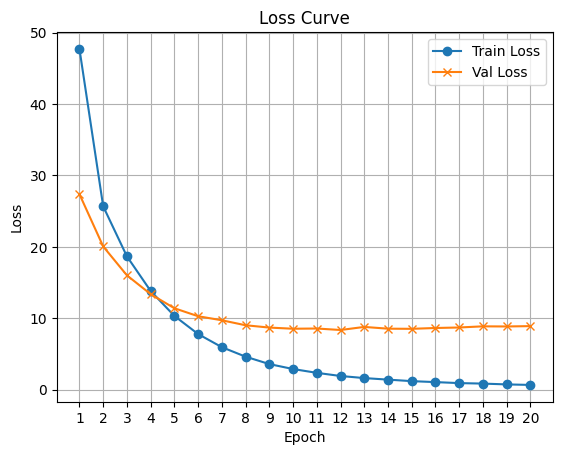

In [33]:
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, marker='x', label='Val Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# 設置 X 軸刻度以 1 為單位
plt.xticks(range(1, len(train_losses) + 1, 1))

plt.show()

In [34]:
validate(model, valid_data_loader, id_to_tag)


Running validation...
Entity          Precision    Recall        F1   Support
-------------------------------------------------------
B-Area             0.8113    0.9773    0.8866        44
B-Exp              0.9600    1.0000    0.9796        24
B-Features         0.8814    1.0000    0.9369        52
B-HackOrg          0.6897    0.7752    0.7299       129
B-Idus             0.8611    0.9688    0.9118        32
B-OffAct           0.6591    0.6591    0.6591        44
B-Org              0.7636    0.7000    0.7304        60
B-Purp             0.7586    0.9851    0.8571        67
B-SamFile          0.9714    0.9444    0.9577        72
B-SecTeam          0.8936    0.7925    0.8400        53
B-Time             0.8312    0.8312    0.8312        77
B-Tool             0.6179    0.6387    0.6281       119
B-Way              0.8293    0.8718    0.8500        78
E-Area             0.8600    0.9773    0.9149        44
E-Exp              0.9600    1.0000    0.9796        24
E-Features         0.9455 

In [35]:
test(model, test_data_loader, id_to_tag)

Running test...
Entity          Precision    Recall        F1   Support
-------------------------------------------------------
B-Area             0.7818    0.8958    0.8350        48
B-Exp              1.0000    1.0000    1.0000        30
B-Features         0.9438    1.0000    0.9711        84
B-HackOrg          0.7833    0.7581    0.7705       124
B-Idus             0.7941    1.0000    0.8852        27
B-OffAct           0.9032    0.8000    0.8485        70
B-Org              0.7191    0.7191    0.7191        89
B-Purp             0.8515    1.0000    0.9198        86
B-SamFile          0.9589    0.9589    0.9589        73
B-SecTeam          0.8696    0.8511    0.8602        47
B-Time             0.9048    0.9620    0.9325        79
B-Tool             0.7561    0.7623    0.7592       122
B-Way              0.8974    1.0000    0.9459        70
E-Area             0.8750    0.8750    0.8750        48
E-Exp              0.9677    1.0000    0.9836        30
E-Features         0.9438    1.0

In [ ]:
test(model, train_data_loader, id_to_tag)